In [1]:
import sys
sys.path.append("../..")
from community_accessibility import *

set_plot_formatting()

In [4]:
original_vulnerability_filename = '../inputs/Vulnerabilities_original.h5'

In [9]:
def plot_vulnerability(vulnerability, k, metric, xaxis, n_points, marker):
    
    if metric == 'functional repair':
        metric_idx = 2
        ylabel = 'Functional Repair Time (days)'
    elif metric == 'stable repair':
        metric_idx = 0
        ylabel = 'Time for stability repair (days)'
    elif metric == 'repair cost':
        metric_idx = 11
        ylabel = 'Repair Cost\nfraction of replacement'
    elif metric == 'structural repair class':
        metric_idx = 4
        ylabel = 'Structural Repair Class'
    elif metric == 'non-structural repair class':
        metric_idx = 5
        ylabel = 'Non-Structural Repair Class'
    elif metric == 'residual drift':
        metric_idx = 7
        ylabel = 'Residual Drift, %'
    else:
        raise ValueError('vulnerability metric is not recognized')
    
    
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    
    date = vulnerability[k].attrs.__getitem__('Bldg_date')[0]
    n_stories = vulnerability[k].attrs.__getitem__('Bldg_nStories')[0]
    str_system = vulnerability[k].attrs.__getitem__('Bldg_strSystem')
    t = vulnerability[k].attrs.__getitem__('Bldg_period')[0]
    sa = vulnerability[k].attrs.__getitem__('saValues')
    replacement_time = vulnerability[k].attrs.__getitem__('Bldg_replacementTime')[0]
    n_IM = len(sa)
    if xaxis == 'index':
        x = np.arange(n_IM)
    elif xaxis == 'absolute':
        x = sa
    else:
        raise ValueError('x axis is not defined')
    
    [_,_,n_realizations] = vulnerability[k].shape
    pt_where = np.random.choice(n_realizations, n_points, replace=False)
    pt_idx = np.zeros(n_realizations, dtype='bool')
    pt_idx[pt_where] = True
    
    q = [5, 33, 50, 67, 95]
    percentiles = np.empty([n_IM, len(q)])
    for h in range(n_IM):
        values = vulnerability[k][h,metric_idx,:]            
        percentiles[h,:] = np.percentile(values, q)
        index = x[h] * np.ones(n_points)
        xlim = 0
        if marker == 'points':
            _ = plt.plot(index, values[pt_idx], color='gray', linestyle='', marker='o', markersize=0.5)
            if index[0] > xlim:
                xlim = index
        elif marker == 'ticks':
            # The segments array for a line collection
            # needs to be (numlines) x (points per line) x 2 (for x and y)
            segments = np.zeros([n_points, 2, 2])
            segments[:,0,1] = values[pt_idx]
            segments[:,1,1] = values[pt_idx]
            tick_width = 0.0075
            segments[:,0,0] = index-tick_width/2
            segments[:,1,0] = index+tick_width/2
            line_segments = LineCollection(segments, linewidths=0.75,
                               color='k', alpha=0.5)
            _ = ax.add_collection(line_segments)
            if index[0]+tick_width/2 > xlim:
                xlim = index[0]+tick_width/2
            
    alpha = 0.15
    label = '  '+str(q[0]) + '-' + str(q[4]) + 'th percentile'
    legend = [Patch(label=label, color='k', alpha=alpha)]
    _ = plt.fill_between(x, percentiles[:,0], percentiles[:,4], color='k', alpha=alpha, label=label)
    label = str(q[1]) + '-' + str(q[3]) + 'th percentile'
    legend = [Patch(label=label, color='k', alpha=2*alpha)] + legend
    _ = plt.fill_between(x, percentiles[:,1], percentiles[:,3], color='k', alpha=alpha, label=label)

    _ = plt.xlabel('Shaking Intensity, Sa(' + '{:.1f}'.format(t) + ' s) [g]')    
    _ = plt.ylabel(ylabel)
    
    _ = plt.legend(handles=legend, loc='upper left')
    
    title = '{:.0f}'.format(date) + ', ' + '{:.0f}'.format(n_stories) + ' story ' + str_system
    _ = plt.title(title)
    
    # force a manual title
    title = '{:.0f}'.format(date) + ', ' + '{:.0f}'.format(n_stories) + ' story Steel Moment Frame'
    _ = plt.title(title)
    
    _ = ax.spines['right'].set_visible(False)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.set_ylim([0, replacement_time*1.01])
    _ = ax.set_xlim([0, xlim])

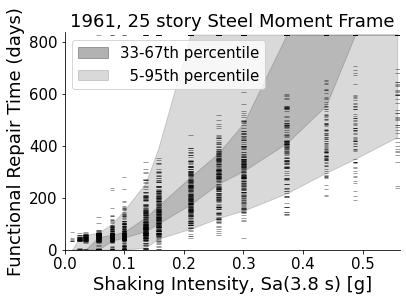

In [10]:
bldg_id = 'SF201006.0000806'
n_points = 250

filename = original_vulnerability_filename
with h5py.File(filename, 'r') as vulnerability:

    plot_vulnerability(vulnerability, bldg_id, 'functional repair', xaxis='absolute', n_points=n_points, marker='ticks')
    filename = bldg_id[9:] + '_vulnerability'
    _ = plt.savefig('figures_png/'+filename+'.png', dpi=300, bbox_inches='tight')
    _ = plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight')
